#Importing the libraries and reading the data from csv

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('data.csv')


In [ ]:
df

,Year,Month,Day,Weekday,Order_count,Product_Tonnage,Revenue
0,2021.0,4.0,28.0,3,5,56.00,2522.13
1,2021.0,4.0,29.0,4,28,417.17,23357.30
2,2021.0,5.0,1.0,6,22,201.81,16965.29
3,2021.0,5.0,2.0,7,26,275.18,18056.65
4,2021.0,5.0,3.0,1,23,209.00,9496.33
...,...,...,...,...,...,...,...
1104,2024.0,8.0,30.0,5,209,5521.13,116047.66
1105,2024.0,8.0,31.0,6,189,5744.16,119485.33
1106,2024.0,9.0,2.0,1,198,9373.88,111611.90
1107,2024.0,9.0,3.0,2,257,15099.63,145620.58


#Checking for missing values and handelling them

In [ ]:
import pandas as pd

def process_dataframe(df):
    # Convert 'Year', 'Month', and 'Day' columns to integer types
    df['Year'] = df['Year'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Day'] = df['Day'].astype(int)

    # Check for missing values and handle them (e.g., filling with zeros or other strategy)
    if df.isnull().values.any():
        print("Missing values found. Handling missing values.")
        df = df.dropna()  # dropping missing values
    else:
        print("No missing values found.")

    return df

# Process the DataFrame
df = process_dataframe(df)

# Display the processed DataFrame
print(df)


No missing values found.
      Year  Month  Day  Weekday  Order_count  Product_Tonnage    Revenue
0     2021      4   28        3            5            56.00    2522.13
1     2021      4   29        4           28           417.17   23357.30
2     2021      5    1        6           22           201.81   16965.29
3     2021      5    2        7           26           275.18   18056.65
4     2021      5    3        1           23           209.00    9496.33
...    ...    ...  ...      ...          ...              ...        ...
1104  2024      8   30        5          209          5521.13  116047.66
1105  2024      8   31        6          189          5744.16  119485.33
1106  2024      9    2        1          198          9373.88  111611.90
1107  2024      9    3        2          257         15099.63  145620.58
1108  2024      9    4        3          183          9343.41   93660.12

[1109 rows x 7 columns]


# Outlier detection and handelling

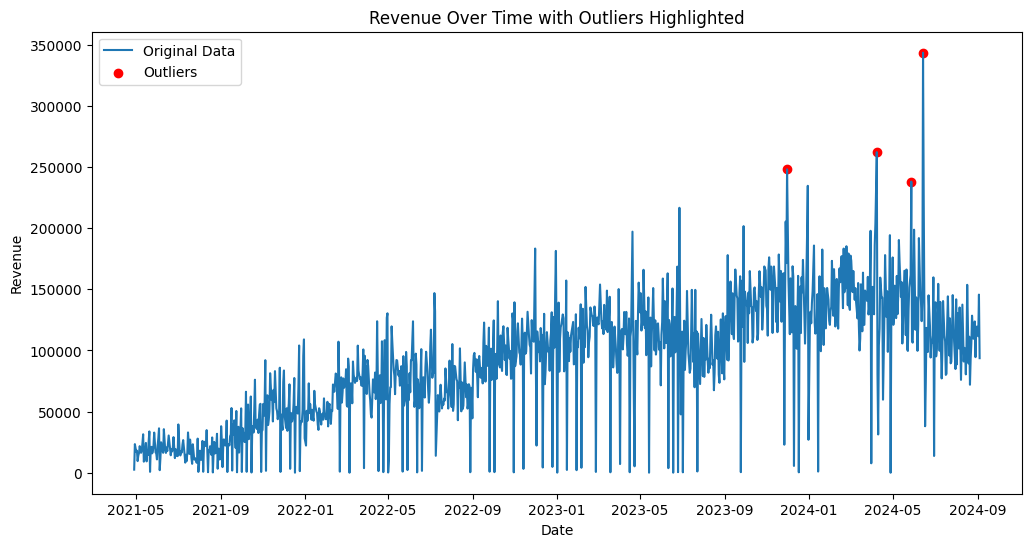

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_outliers_zscore(df, threshold=3):
    """
    Detect outliers using z-score method.
    """
    # Convert 'Revenue' column to numeric
    df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')

    # Drop rows with NaN values in 'Revenue' column
    df = df.dropna(subset=['Revenue'])

    mean = df['Revenue'].mean()
    std_dev = df['Revenue'].std()
    z_scores = np.abs((df['Revenue'] - mean) / std_dev)
    outliers = df[z_scores > threshold]
    return outliers

def plot_outliers(df, outliers):
    """
    Plot the original data and highlight the outliers.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Revenue'], label='Original Data')
    plt.scatter(outliers['Date'], outliers['Revenue'], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Revenue Over Time with Outliers Highlighted')
    plt.legend()
    plt.show()

# Create a 'Date' column from 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Detect outliers using z-score
outliers_zscore = detect_outliers_zscore(df)

# Plot outliers
plot_outliers(df, outliers_zscore)

# Plotting ACF

<Figure size 1200x600 with 0 Axes>

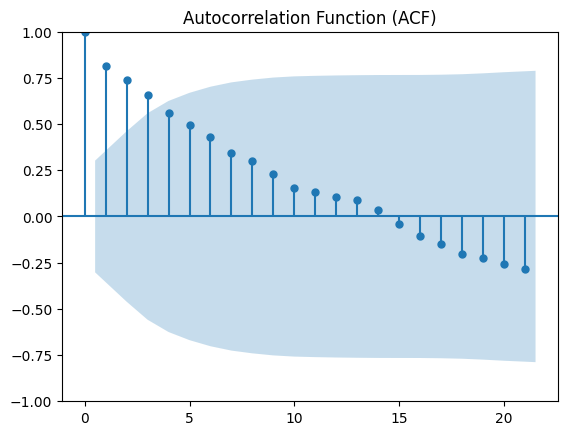

<Figure size 1200x600 with 0 Axes>

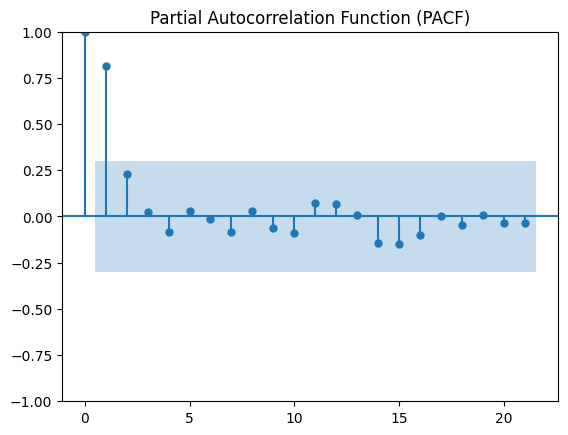

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

# Assuming df is your DataFrame containing 'Year', 'Month', and 'Revenue'

# Convert 'Year' and 'Month' to datetime
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group by 'Date' and sum the 'Revenue' for each month
monthly_revenue = df.groupby('Date')['Revenue'].sum()

# Determine the number of lags dynamically, ensuring it doesn't exceed half the length of the data
max_lags = min(48, len(monthly_revenue) // 2)

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(monthly_revenue, lags=max_lags)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(monthly_revenue, lags=max_lags)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


# 3 Months moving avergae model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

def moving_average_forecast(df, training_end_date, prediction_steps, window_size=3):
    # Convert 'Year' and 'Month' to datetime
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

    # Group by 'Date' and sum the 'Revenue' for each month
    monthly_revenue = df.groupby('Date')['Revenue'].sum()

    # Define the training data up to the specified end date
    train_data = monthly_revenue[:training_end_date]

    # Calculate the moving average
    moving_avg = train_data.rolling(window=window_size).mean()

    # Define the test period based on the forecast steps
    test_start_date = pd.to_datetime(training_end_date) + pd.DateOffset(months=1)
    test_end_date = test_start_date + pd.DateOffset(months=prediction_steps-1)
    test_data = monthly_revenue[test_start_date:test_end_date]

    # Predict the future values using the moving average
    last_moving_avg = moving_avg.iloc[-1]
    forecast = np.full(prediction_steps, last_moving_avg)

    # Calculate the sum of predicted and actual revenues
    sum_predicted = forecast.sum()
    sum_actual = test_data.sum()

    # Calculate MAPE for each month
    mape_values = []
    for actual, predicted in zip(test_data, forecast):
        mape = mean_absolute_percentage_error([actual], [predicted])
        mape_values.append(mape)

    overall_mape = mean_absolute_percentage_error(test_data, forecast)

    # Print the results
    print(f"Sum of Predicted Revenue ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {sum_predicted:.2f}")
    print(f"Sum of Actual Revenue ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {sum_actual:.2f}")
    print(f"Overall MAPE: {overall_mape:.2f}")

    # Print individual months' results
    for i, (actual, predicted, mape) in enumerate(zip(test_data, forecast, mape_values)):
        month = (test_start_date + pd.DateOffset(months=i)).strftime('%b-%Y')
        print(f"Month: {month}, Actual Revenue: {actual:.2f}, Predicted Revenue: {predicted:.2f}, MAPE: {mape:.2f}")

    # If you want to see the forecast values and actual values
    print(f"Predicted Revenues ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {forecast.tolist()}")
    print(f"Actual Revenues ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {test_data.tolist()}")


moving_average_forecast(df, '2024-04-01', 3)


Sum of Predicted Revenue (May-2024 to Jul-2024): 11112140.36
Sum of Actual Revenue (May-2024 to Jul-2024): 10248068.42
Overall MAPE: 0.12
Month: May-2024, Actual Revenue: 3852774.80, Predicted Revenue: 3704046.79, MAPE: 0.04
Month: Jun-2024, Actual Revenue: 3397918.53, Predicted Revenue: 3704046.79, MAPE: 0.09
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3704046.79, MAPE: 0.24
Predicted Revenues (May-2024 to Jul-2024): [3704046.7866666666, 3704046.7866666666, 3704046.7866666666]
Actual Revenues (May-2024 to Jul-2024): [3852774.8, 3397918.5300000003, 2997375.09]


In [ ]:
moving_average_forecast(df, '2024-05-01', 3)

Sum of Predicted Revenue (Jun-2024 to Aug-2024): 11186569.95
Sum of Actual Revenue (Jun-2024 to Aug-2024): 9334130.44
Overall MAPE: 0.20
Month: Jun-2024, Actual Revenue: 3397918.53, Predicted Revenue: 3728856.65, MAPE: 0.10
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3728856.65, MAPE: 0.24
Month: Aug-2024, Actual Revenue: 2938836.82, Predicted Revenue: 3728856.65, MAPE: 0.27
Predicted Revenues (Jun-2024 to Aug-2024): [3728856.65, 3728856.65, 3728856.65]
Actual Revenues (Jun-2024 to Aug-2024): [3397918.5300000003, 2997375.09, 2938836.82]


In [ ]:
moving_average_forecast(df, '2024-06-01', 2)

Sum of Predicted Revenue (Jul-2024 to Aug-2024): 7219409.92
Sum of Actual Revenue (Jul-2024 to Aug-2024): 5936211.91
Overall MAPE: 0.22
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3609704.96, MAPE: 0.20
Month: Aug-2024, Actual Revenue: 2938836.82, Predicted Revenue: 3609704.96, MAPE: 0.23
Predicted Revenues (Jul-2024 to Aug-2024): [3609704.9599999995, 3609704.9599999995]
Actual Revenues (Jul-2024 to Aug-2024): [2997375.09, 2938836.82]


# Model Avergae MAPE comes to 0.20

# ARIMA model

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

def arima_forecast(df, training_end_date, prediction_steps, arima_order):
    # Convert 'Year' and 'Month' to datetime
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

    # Group by 'Date' and sum the 'Revenue' for each month
    monthly_revenue = df.groupby('Date')['Revenue'].sum()

    # Define the training data up to the specified end date
    train_data = monthly_revenue[:training_end_date]

    # Fit the ARIMA model with the specified order
    model = ARIMA(train_data, order=arima_order)
    model_fit = model.fit()

    # Predict for the specified number of steps
    forecast = model_fit.forecast(steps=prediction_steps)

    # Define the test period based on the forecast steps
    test_start_date = pd.to_datetime(training_end_date) + pd.DateOffset(months=1)
    test_end_date = test_start_date + pd.DateOffset(months=prediction_steps-1)
    test_data = monthly_revenue[test_start_date:test_end_date]

    # Calculate the sum of predicted and actual revenues
    sum_predicted = forecast.sum()
    sum_actual = test_data.sum()

    # Calculate MAPE for each month
    mape_values = []
    for actual, predicted in zip(test_data, forecast):
        mape = mean_absolute_percentage_error([actual], [predicted])
        mape_values.append(mape)

    overall_mape = mean_absolute_percentage_error(test_data, forecast)

    # Print the results
    print(f"Sum of Predicted Revenue ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {sum_predicted:.2f}")
    print(f"Sum of Actual Revenue ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {sum_actual:.2f}")
    print(f"Overall MAPE: {overall_mape:.2f}")

    # Print individual months' results
    for i, (actual, predicted, mape) in enumerate(zip(test_data, forecast, mape_values)):
        month = (test_start_date + pd.DateOffset(months=i)).strftime('%b-%Y')
        print(f"Month: {month}, Actual Revenue: {actual:.2f}, Predicted Revenue: {predicted:.2f}, MAPE: {mape:.2f}")

    # If you want to see the forecast values and actual values
    print(f"Predicted Revenues ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {forecast.tolist()}")
    print(f"Actual Revenues ({test_start_date.strftime('%b-%Y')} to {test_end_date.strftime('%b-%Y')}): {test_data.tolist()}")





In [ ]:
arima_forecast(df, '2023-12', 3, (1,1,1))

Sum of Predicted Revenue (Jan-2024 to Mar-2024): 11411256.41
Sum of Actual Revenue (Jan-2024 to Mar-2024): 10998651.41
Overall MAPE: 0.04
Month: Jan-2024, Actual Revenue: 3464932.60, Predicted Revenue: 3800203.38, MAPE: 0.10
Month: Feb-2024, Actual Revenue: 3778345.21, Predicted Revenue: 3806136.25, MAPE: 0.01
Month: Mar-2024, Actual Revenue: 3755373.60, Predicted Revenue: 3804916.78, MAPE: 0.01
Predicted Revenues (Jan-2024 to Mar-2024): [3800203.3827898763, 3806136.249783274, 3804916.775207209]
Actual Revenues (Jan-2024 to Mar-2024): [3464932.6, 3778345.21, 3755373.6]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
arima_forecast(df, '2024-1', 3, (1,1,1))

Sum of Predicted Revenue (Feb-2024 to Apr-2024): 10334020.51
Sum of Actual Revenue (Feb-2024 to Apr-2024): 11112140.36
Overall MAPE: 0.07
Month: Feb-2024, Actual Revenue: 3778345.21, Predicted Revenue: 3440970.17, MAPE: 0.09
Month: Mar-2024, Actual Revenue: 3755373.60, Predicted Revenue: 3447383.38, MAPE: 0.08
Month: Apr-2024, Actual Revenue: 3578421.55, Predicted Revenue: 3445666.97, MAPE: 0.04
Predicted Revenues (Feb-2024 to Apr-2024): [3440970.165965222, 3447383.376615792, 3445666.9703947506]
Actual Revenues (Feb-2024 to Apr-2024): [3778345.21, 3755373.6, 3578421.55]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
arima_forecast(df, '2024-2', 3, (1,1,1))

Sum of Predicted Revenue (Mar-2024 to May-2024): 11422635.67
Sum of Actual Revenue (Mar-2024 to May-2024): 11186569.95
Overall MAPE: 0.03
Month: Mar-2024, Actual Revenue: 3755373.60, Predicted Revenue: 3815152.11, MAPE: 0.02
Month: Apr-2024, Actual Revenue: 3578421.55, Predicted Revenue: 3801034.19, MAPE: 0.06
Month: May-2024, Actual Revenue: 3852774.80, Predicted Revenue: 3806449.36, MAPE: 0.01
Predicted Revenues (Mar-2024 to May-2024): [3815152.1144415014, 3801034.1912200283, 3806449.364245627]
Actual Revenues (Mar-2024 to May-2024): [3755373.6, 3578421.55, 3852774.8]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
arima_forecast(df, '2024-5', 3, (1,1,1))

Sum of Predicted Revenue (Jun-2024 to Aug-2024): 11626767.62
Sum of Actual Revenue (Jun-2024 to Aug-2024): 9334130.44
Overall MAPE: 0.25
Month: Jun-2024, Actual Revenue: 3397918.53, Predicted Revenue: 3882080.13, MAPE: 0.14
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3869749.68, MAPE: 0.29
Month: Aug-2024, Actual Revenue: 2938836.82, Predicted Revenue: 3874937.81, MAPE: 0.32
Predicted Revenues (Jun-2024 to Aug-2024): [3882080.1287476313, 3869749.6800021343, 3874937.813790861]
Actual Revenues (Jun-2024 to Aug-2024): [3397918.5300000003, 2997375.09, 2938836.82]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
arima_forecast(df, '2024-6', 2, (1,1,1))

Sum of Predicted Revenue (Jul-2024 to Aug-2024): 6741982.90
Sum of Actual Revenue (Jul-2024 to Aug-2024): 5936211.91
Overall MAPE: 0.14
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3362478.31, MAPE: 0.12
Month: Aug-2024, Actual Revenue: 2938836.82, Predicted Revenue: 3379504.59, MAPE: 0.15
Predicted Revenues (Jul-2024 to Aug-2024): [3362478.3137332844, 3379504.5897446475]
Actual Revenues (Jul-2024 to Aug-2024): [2997375.09, 2938836.82]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
arima_forecast(df, '2024-1', 7, (1,1,1))

Sum of Predicted Revenue (Feb-2024 to Aug-2024): 24118214.05
Sum of Actual Revenue (Feb-2024 to Aug-2024): 24299045.60
Overall MAPE: 0.09
Month: Feb-2024, Actual Revenue: 3778345.21, Predicted Revenue: 3440970.17, MAPE: 0.09
Month: Mar-2024, Actual Revenue: 3755373.60, Predicted Revenue: 3447383.38, MAPE: 0.08
Month: Apr-2024, Actual Revenue: 3578421.55, Predicted Revenue: 3445666.97, MAPE: 0.04
Month: May-2024, Actual Revenue: 3852774.80, Predicted Revenue: 3446126.34, MAPE: 0.11
Month: Jun-2024, Actual Revenue: 3397918.53, Predicted Revenue: 3446003.40, MAPE: 0.01
Month: Jul-2024, Actual Revenue: 2997375.09, Predicted Revenue: 3446036.30, MAPE: 0.15
Month: Aug-2024, Actual Revenue: 2938836.82, Predicted Revenue: 3446027.50, MAPE: 0.17
Predicted Revenues (Feb-2024 to Aug-2024): [3440970.165965222, 3447383.376615792, 3445666.9703947506, 3446126.3425370594, 3446003.3980018194, 3446036.3023888147, 3446027.495989397]
Actual Revenues (Feb-2024 to Aug-2024): [3778345.21, 3755373.6, 3578421.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Average model accuracy comes to 0.09%

# SARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-50-d093a9c8da37>:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  forecast_df = forecast_df.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)


Predicted Revenues (Apr-2024 to Sep-2024):
                 Date Predicted_Revenue Lower_Bound Upper_Bound
2024-04-01 2024-04-30        3712801.84  3421854.30  4003749.37
2024-05-01 2024-05-31        3988213.79  3679914.79  4296512.80
2024-06-01 2024-06-30        3918410.96  3593686.33  4243135.59
2024-07-01 2024-07-31        3560141.70  3219783.22  3900500.17
2024-08-01 2024-08-31        3504036.22  3148731.14  3859341.30
2024-09-01 2024-09-30        4272754.55  3903106.74  4642402.37


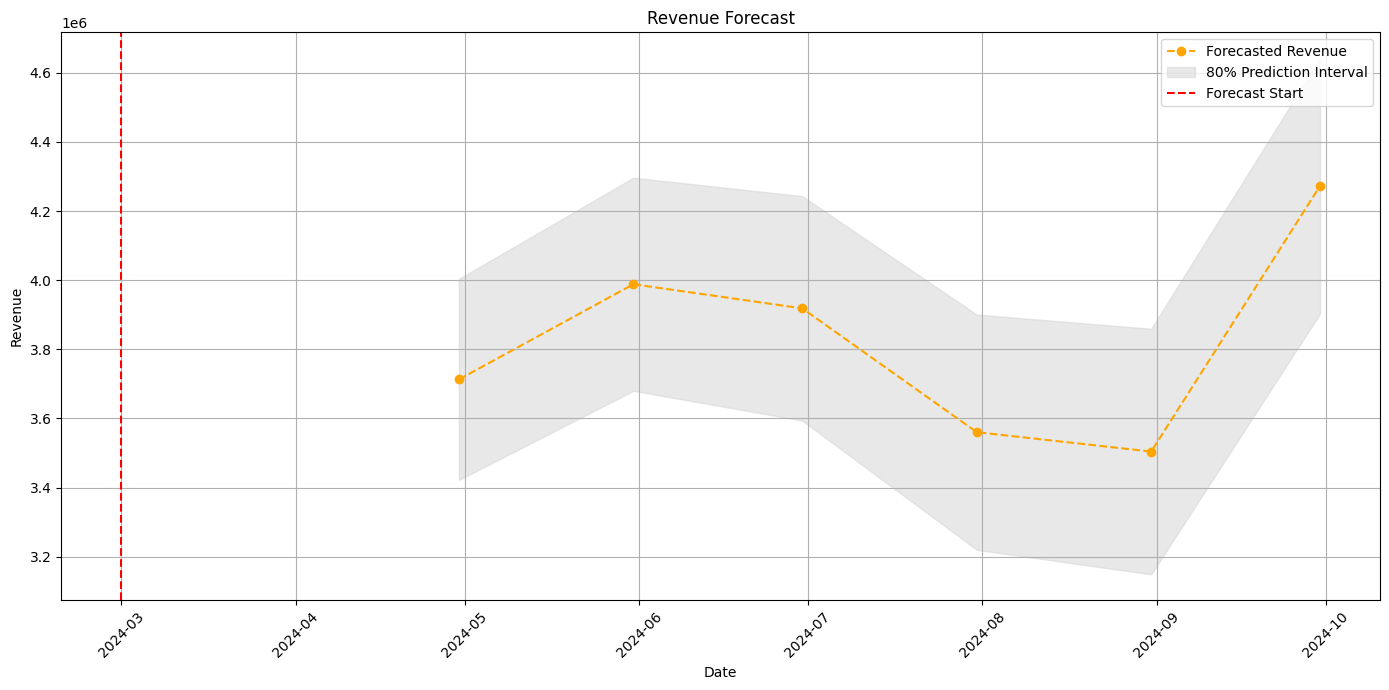

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def sarima_future_forecast(df, training_end_date, prediction_steps, sarima_order, seasonal_order, confidence_level):
    # Convert 'Year' and 'Month' to datetime
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

    # Group by 'Date' and sum the 'Revenue' for each month
    monthly_revenue = df.groupby('Date')['Revenue'].sum()

    # Define the training data up to the specified end date
    train_data = monthly_revenue[:training_end_date]

    # Fit the SARIMA model with the specified order
    model = SARIMAX(train_data, order=sarima_order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Predict for the specified number of steps
    forecast_result = model_fit.get_forecast(steps=prediction_steps)
    forecast = forecast_result.predicted_mean
    alpha = 1 - confidence_level
    forecast_ci = forecast_result.conf_int(alpha=alpha)

    # Define the forecast period based on the prediction steps
    forecast_start_date = pd.to_datetime(training_end_date) + pd.DateOffset(months=1)
    forecast_dates = pd.date_range(start=forecast_start_date, periods=prediction_steps, freq='M')

    # Create a DataFrame with the forecasted values and confidence intervals
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Predicted_Revenue': forecast,
        'Lower_Bound': forecast_ci.iloc[:, 0],
        'Upper_Bound': forecast_ci.iloc[:, 1]
    })

    # Format the values to display without scientific notation
    forecast_df = forecast_df.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

    print(f"Predicted Revenues ({forecast_start_date.strftime('%b-%Y')} to {forecast_dates[-1].strftime('%b-%Y')}):")
    print(forecast_df)

    return forecast_df

def plot_sarima_forecast(df, forecast_df, training_end_date, confidence_level):
    # Convert 'Year' and 'Month' to datetime for actual data
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    actuals = df.set_index('Date')['Revenue']

    # Extract forecast details
    forecast_dates = pd.to_datetime(forecast_df['Date'])
    forecast_values = forecast_df['Predicted_Revenue'].astype(float)
    lower_bound = forecast_df['Lower_Bound'].astype(float)
    upper_bound = forecast_df['Upper_Bound'].astype(float)

    # Filter actuals to only include dates within the forecast period
    actuals_in_forecast_period = actuals[actuals.index.isin(forecast_dates)]

    # Create the plot
    plt.figure(figsize=(14, 7))

    # Plot the actual revenue for forecast period if available
    if not actuals_in_forecast_period.empty:
        plt.plot(actuals_in_forecast_period.index, actuals_in_forecast_period.values, label='Actual Revenue', color='blue', marker='o')

    # Plot the forecasted revenue
    plt.plot(forecast_dates, forecast_values, label='Forecasted Revenue', color='orange', linestyle='--', marker='o')

    # Fill the confidence interval
    plt.fill_between(forecast_dates, lower_bound, upper_bound, color='lightgrey', alpha=0.5, label=f'{int(confidence_level * 100)}% Prediction Interval')

    # Add a vertical line to denote the start of the forecast
    plt.axvline(pd.to_datetime(training_end_date), color='red', linestyle='--', label='Forecast Start')

    # Additional plot settings
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.title('Revenue Forecast')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# Set the confidence level (e.g., 80% confidence level corresponds to alpha=0.20)
confidence_level = 0.80

# SARIMA parameters
sarima_order = (0, 1, 1)  # ARIMA part of the model
seasonal_order = (1, 1, 0, 12)  # SARIMA part of the model (seasonal component, assuming 12 months for yearly seasonality)

# Forecasting
forecast_df = sarima_future_forecast(df, '2024-03', 6, sarima_order, seasonal_order, confidence_level)

# Plotting
plot_sarima_forecast(df, forecast_df, '2024-03', confidence_level)


#This model give an average accuracy of 95 % and MAPE less than 0.05 which indicates thsis is the best mode now we take tihs data store in a new csv and export to the poweri bi dashboard

In [ ]:
forecast_df.to_csv('forecast_df.csv', index=False)